In [91]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from validation.metrics import OME, MSE
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, PowerTransformer
from MODELS.ViscNN import create_ViscNN, create_ViscNN_concat,create_ViscNN_comb, create_ViscNN_phys, above_Mcr, Mcr_gpr_train
from validation.tests import viscNN_LC, crossval_NN, Mw_extrapolation, Mw_test, evaluate_model, crossval_compare, shear_extrapolation, shear_test
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
import keras.backend as K
import keras
pd.options.mode.chained_assignment = None  # default='warn'

In [146]:
data = pd.read_excel('Data/full_data_2021-12-28.xlsx')

In [147]:
data.shape

(1478, 233)

In [148]:
extrap, PL_data, extrap_samps = Mw_extrapolation(data.copy(), 10)
#data = pd.concat([data, extrap], ignore_index = True).reset_index(drop = True)

Found Zero Shear Samples
Found LOBF for samples
Generating sample...0
Generating sample...1
Generating sample...2
Generating sample...3
Generating sample...4
Generating sample...5
Generating sample...6
Generating sample...7
Generating sample...8
Generating sample...9


In [149]:
shear_samps = shear_extrapolation(data.copy())

In [150]:
OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)

In [151]:
do_pca = True
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

208
Explained variance (ratio): [8.32557421e-01 9.55036919e-02 1.80684215e-02 1.20310856e-02
 7.72840962e-03 5.55583779e-03 4.33123075e-03 3.81099158e-03
 3.39715491e-03 2.69047851e-03 1.85046285e-03 1.36321263e-03
 1.25112141e-03 8.90611426e-04 8.54997584e-04 7.62831385e-04
 6.68179895e-04]
Total variance in 17 components = 0.9933161407360477


In [152]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
        #data = data.drop([i])

In [153]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols + ['Polymer', 'SHEAR', 'ZERO_SHEAR', 'log_Shear_Rate']].dropna(subset = ['Mw', 'Shear_Rate'])
#X_tot = np.array(filtered_data.filter(fp_cols + ['SHEAR', 'ZERO_SHEAR']))
X_tot = np.array(filtered_data.filter(fp_cols))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [154]:
logMw = np.array(filtered_data['Mw']).reshape((tot_samples,1))
log_shear = np.array(filtered_data['log_Shear_Rate']).reshape((tot_samples,1))
shear = np.array(filtered_data['Shear_Rate']).reshape((tot_samples,1))
Temp = np.array(filtered_data['Temperature']).reshape((tot_samples,1))
scaler = MinMaxScaler(copy = False)
scaler.fit(X_tot).transform(X_tot);
#y_scaler = MinMaxScaler(copy = False)
#y_scaler.fit(Y_tot).transform(Y_tot);
#S_scaler = MaxAbsScaler().fit(log_shear)
#log_shear = S_scaler.transform(log_shear)
T_scaler = MinMaxScaler().fit(Temp)
Temp = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
logMw = M_scaler.transform(logMw);
S_trans = PowerTransformer(standardize = False).fit(shear)
S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
shear = S_scaler.transform(S_trans.transform(shear))
gpr_Mcr = Mcr_gpr_train(OG_fp, pca, M_scaler, scaler)

In [259]:
S_trans.lambdas_

array([-0.20024025])

In [227]:
XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind, gr_Mcr, gr_Mcr_test = train_test_split(X_tot, Y_tot, logMw, shear, Temp, range(tot_samples), np.array(above_Mcr(logMw, Mcr = gpr_Mcr.predict_y(X_tot)[0])), test_size= 0.10)

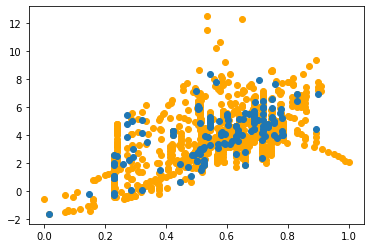

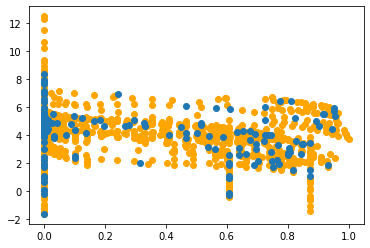

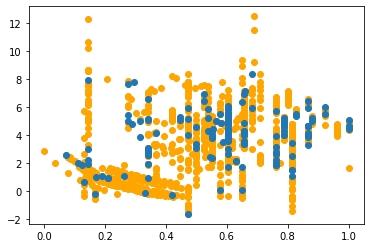

In [228]:
plt.scatter(M, yy, c = 'orange')
plt.scatter(M_test, y_test)

plt.figure()
plt.scatter(S, yy, c = 'orange')
plt.scatter(S_test, y_test)

plt.figure()
plt.scatter(T, yy, c = 'orange')
plt.scatter(T_test, y_test)

In [229]:
models, history, gpr_models, gp_cv  = crossval_compare([create_ViscNN_phys, create_ViscNN_concat], XX, yy, M=M, S=S, T=T, gr_Mcr=gr_Mcr, verbose = 1, random_state = 75, gpr_model = create_GPR)

Trained fold 1 ...
CV Error create_ViscNN_phys: 0.946223795413971
CV Error create_ViscNN_concat: 0.47076714038848877
CV Error GPR: 0.4418597126212875
Trained fold 2 ...
CV Error create_ViscNN_phys: 0.5459723472595215
CV Error create_ViscNN_concat: 0.28757187724113464
CV Error GPR: 0.17573956830520052
Trained fold 3 ...
CV Error create_ViscNN_phys: 0.5634554028511047
CV Error create_ViscNN_concat: 0.3951284885406494
CV Error GPR: 0.07575696109178354
Trained fold 4 ...
CV Error create_ViscNN_phys: 0.6798995733261108
CV Error create_ViscNN_concat: 0.33457499742507935
CV Error GPR: 0.15225097384921876
Trained fold 5 ...
CV Error create_ViscNN_phys: 1.0677913427352905
CV Error create_ViscNN_concat: 0.6637904644012451
CV Error GPR: 0.13980375675353235
Trained fold 6 ...
CV Error create_ViscNN_phys: 0.39353540539741516
CV Error create_ViscNN_concat: 0.201869398355484
CV Error GPR: 0.07062155462840855
Trained fold 7 ...
CV Error create_ViscNN_phys: 0.6246703863143921
CV Error create_ViscNN_con

Test OME:12.6707535


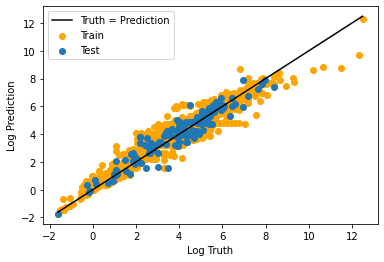

In [230]:
m_P = models[0][5]

test_pred =  m_P.predict([X_test, M_test, S_test, T_test, gr_Mcr_test])
train_pred = m_P.predict([XX, M, S, T, gr_Mcr])
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)
#print("Test MSE:" + str(model.evaluate([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
#print("Test OME:" + str(OME(model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]), y_test).numpy()))
#print("Test MSE:" + str(model.evaluate([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
print("Test OME:" + str(OME(test_pred, y_test).numpy()))

In [160]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['Error'] > 2]

0.8620001562432996


,0,1,2,3,4,5,6,7,8,9,...,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,Y_pred,Error,BAD_PRED
607,-0.399525,-0.035769,-1.196566,1.274073,0.347111,-0.456602,-0.239314,0.561085,0.485379,0.006981,...,232.0,0.0,11.487138,"Poly(2,6-dimethyl 1,4-phenylene oxide)",0,1,0.0,3.974874,7.512265,True
430,-0.449044,-0.020171,-0.342884,-0.102979,-0.377450,0.015468,0.195777,0.029891,-0.242060,-0.213824,...,25.0,0.0,4.126582,polybutadiene,0,1,0.0,2.106596,2.019987,True
174,-0.400568,-0.024780,-1.972367,1.532369,1.372390,-0.793578,-0.117170,0.176124,0.861302,-0.047916,...,200.0,0.0,3.845098,polyethene,0,1,0.0,6.062875,2.217777,True
1373,-0.040373,0.455534,-0.088592,-0.696328,-0.580864,-0.366371,0.152544,-0.462110,-0.163748,-0.068961,...,169.0,0.0,7.551450,"Poly(4-vinyl phenol), Poly(ethylene oxide)",0,1,0.0,1.424464,6.126986,True


Test OME:9.876018


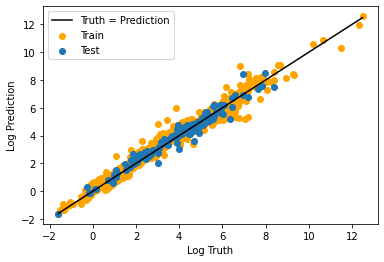

In [231]:
m_NP = models[1][5]
test_pred =  m_NP.predict([X_test, M_test, S_test, T_test, gr_Mcr_test])
train_pred = m_NP.predict([XX, M, S, T, gr_Mcr])
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)
#print("Test MSE:" + str(model.evaluate([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
#print("Test OME:" + str(OME(model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]), y_test).numpy()))
#print("Test MSE:" + str(model.evaluate([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
print("Test OME:" + str(OME(test_pred, y_test).numpy()))

In [ ]:
test_pred =  model_phys[5].predict([X_test, M_test, S_test, T_test])
train_pred = model_phys[5].predict([XX, M, S, T])
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)

plt.plot(np.linspace((min(y_log)[0]), (max(y_log)[0]), num = 2),np.linspace((min(y_log)[0]), (max(y_log)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)
#print("Test MSE:" + str(model.evaluate([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
#print("Test OME:" + str(OME(model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]), y_test).numpy()))
#print("Test MSE:" + str(model.evaluate([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
print("Test OME:" + str(OME(test_pred, y_test).numpy()))

In [232]:
#gpr_model = train_GPR(XX, yy, M, S, T)
gpr_model = gpr_models[5]

Test MSE:0.05837435127260369
Test OME:tf.Tensor(3.7443042, shape=(), dtype=float32)


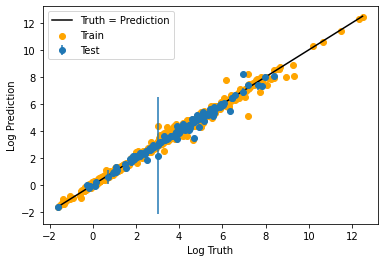

In [233]:
X_ = np.concatenate((X_test, M_test, S_test, T_test), axis = 1)
X_train = np.concatenate((XX, M, S, T), axis = 1)
test_pred, var = gpr_model.predict_y(X_)
## generate 10 samples from posterior
error =  [i[0] for i in np.array(var).tolist()]
print("Test MSE:" + str(MSE(test_pred, y_test)))
print("Test OME:" + str(OME(tf.cast(test_pred, tf.float32), y_test)))

# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
train_pred, var_train = gpr_model.predict_y(X_train)
plt.scatter(yy, train_pred, c = 'orange')
plt.errorbar(y_test, test_pred, [i[0] for i in np.array(var).tolist()], fmt = 'o')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.legend(['Truth = Prediction', 'Train','Test'])
plt.show()

In [213]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]
test_df.reset_index().loc[error.index(max(error))]

0.611334284450041


index                                 319
0                               -1.415321
1                               -0.317701
2                               -0.408195
3                               -0.254904
4                               -1.151726
5                                0.978914
6                               -1.375541
7                               -0.744164
8                                 1.62228
9                               -0.297699
10                              -0.183132
11                              -0.252067
12                               0.097783
13                              -0.026297
14                              -0.086661
15                               0.079117
16                              -0.041229
Mw                                3.90309
Temperature                         265.0
Shear_Rate                            0.0
Melt_Viscosity                        2.0
Polymer           Polytetrafluoroethylene
SHEAR                             

115

In [ ]:
tuner = kt.Hyperband(create_ViscNN_concat, objective='val_loss',
                     max_epochs=10,
                     factor=3, project_name = 'create_ViscNN_concat2')

tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [240]:
k_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('log_k').output)
tau_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('tau').output)
alpha_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('alpha').output)
n_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('n').output)
layer_name2 = 'zero_shear_visc'
z_shear_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer(layer_name2).output)

In [234]:
#PL_data.head(10)
extrap_tests = Mw_test(PL_data.copy(), samps = [0,1,2,3,4,5,6,7,8,9,10,11,12])

  SAMPLE_ID      Polymer   SMILES  Temperature          Mcr    Log_K1  \
2         6  Linear HDPE  [*]C[*]        150.0  3656.398809 -3.904875   

     Log_K2     Alpha  afp_C4_C4_C4  afp_C4_C4_H1  ...  afp_C2_C4_H1  bfp_344  \
2 -13.40241  3.665561      0.333333      1.333333  ...           0.0      0.0   

   mfp_MQNs15  bfp_46  bfp_47  bfp_55  bfp_79  bfp_210  bfp_482  Shear_Rate  
2         0.0       0       0       0       0        0        0           0  

[1 rows x 217 columns]


In [235]:
samp_num = 2
XX_ex, OH, M_ex,S_ex,T_ex,y_ex = extrap_tests[samp_num]['data_in']
print(extrap_tests[samp_num]['tests'])
Mw_ex = extrap_samps[samp_num][0]
log_visc_ex = extrap_samps[samp_num][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex)))
M_ex = M_scaler.transform(M_ex)
S_ex = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(T_ex)
gr_Mcr_ex = np.array(above_Mcr(M_ex, Mcr = gpr_Mcr.predict_y(XX_ex)[0]))

   logMw  Temperature  Shear_Rate      Polymer  afp_C4_C4_C4  afp_C4_C4_H1  \
0    1.0        150.0           0  Linear HDPE      0.333333      1.333333   
1    2.0        150.0           0  Linear HDPE      0.333333      1.333333   
2    3.0        150.0           0  Linear HDPE      0.333333      1.333333   
3    4.0        150.0           0  Linear HDPE      0.333333      1.333333   
4    5.0        150.0           0  Linear HDPE      0.333333      1.333333   
5    6.0        150.0           0  Linear HDPE      0.333333      1.333333   
6    7.0        150.0           0  Linear HDPE      0.333333      1.333333   
7    8.0        150.0           0  Linear HDPE      0.333333      1.333333   
8    9.0        150.0           0  Linear HDPE      0.333333      1.333333   
9   10.0        150.0           0  Linear HDPE      0.333333      1.333333   

   afp_H1_C4_H1  bfp_267  bfp_282  bfp_289  ...  bfp_46  bfp_47  bfp_55  \
0      0.333333      0.0      0.0      1.0  ...     0.0     0.0   

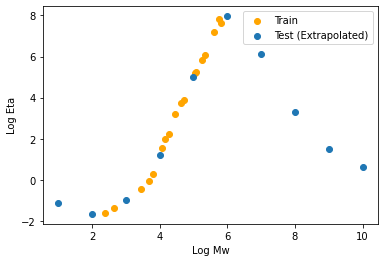

In [236]:
test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex, T_ex), axis = 1))
plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.legend(['Train','Test (Extrapolated)'])

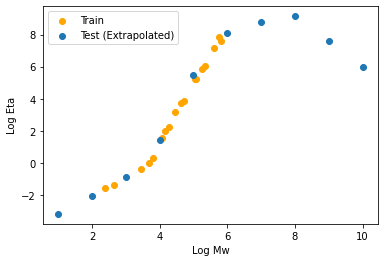

In [237]:
test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])

plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.legend(['Train','Test (Extrapolated)'])

In [238]:
m_P.summary()

Model: "model_111"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_427 (InputLayer)          [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_429 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_431 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_85 (Concatenate)    (None, 19)           0           input_427[0][0]                  
                                                                 input_429[0][0]          

tf.Tensor(
[[-1.8199983]
 [-1.8199983]
 [-1.8199983]
 [-2.9952862]
 [-2.9952862]
 [-2.9952862]
 [-2.9952862]
 [-2.9952862]
 [-2.9952862]
 [-2.9952862]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.9999992]
 [0.9999992]
 [0.9999992]
 [0.9999995]
 [0.9999995]
 [0.9999995]
 [0.9999995]
 [0.9999995]
 [0.9999995]
 [0.9999995]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[1.      ]
 [1.      ]
 [1.      ]
 [3.593877]
 [3.593877]
 [3.593877]
 [3.593877]
 [3.593877]
 [3.593877]
 [3.593877]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.5999998 ]
 [0.5999998 ]
 [0.5999998 ]
 [0.59999955]
 [0.59999955]
 [0.59999955]
 [0.59999955]
 [0.59999955]
 [0.59999955]
 [0.59999955]], shape=(10, 1), dtype=float32)


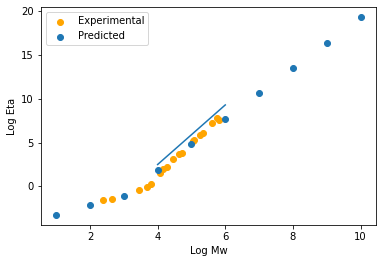

In [241]:
test_pred = m_P.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.legend(['Experimental','Predicted'])
plt.plot([4,6], [2.5, 2.5+(3.4*2)])
print(k_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(tau_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(alpha_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(n_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))

In [252]:
samp_num = shear_samps['SAMPLE_ID'].values[246]
s_test = shear_test(shear_samps, samp_num);
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = s_test['known'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex)))
M_ex = M_scaler.transform(M_ex)
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(T_ex)
gr_Mcr_ex = np.array(above_Mcr(M_ex, Mcr = gpr_Mcr.predict_y(XX_ex)[0]))

   SAMPLE_ID                    Polymer                SMILES  Temperature  \
0      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
1      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
2      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
3      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
4      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
5      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
6      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   
7      354.0  poly(methyl methacrylate)  [*]CC([*])(C)C(=O)OC        220.0   

         Mw   Shear_Rate  Melt_Viscosity  afp_C4_C4_C4  afp_C4_C4_H1  \
0  4.857332    41.132433        4.422961      0.266667      0.466667   
1  4.857332    83.285112        4.268882      0.266667      0.466667   
2  4.857332   167.538057        4.090634      0.266667      0.466667   
3  4.8573

tf.Tensor(
[[-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]
 [-3.4464896]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.6]
 [0.6]
 [0.6]
 [0.6]
 [0.6]
 [0.6]
 [0.6]
 [0.6]
 [0.6]
 [0.6]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]
 [3.9309132]], shape=(10, 1), dtype=float32)


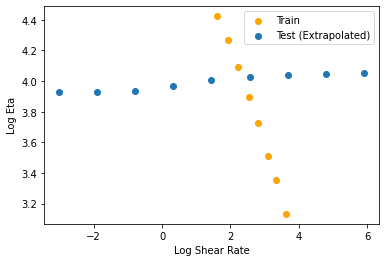

In [253]:
test_pred = m_P.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])

plt.figure()
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
plt.scatter(np.log10(S_ex[:-1]), test_pred[:-1])
plt.legend(['Train','Test (Extrapolated)'])
#print(params_layer([XX_ex, M_ex, S_ex_trans, T_ex]))
#z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex])
print(k_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
print(tau_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
print(n_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
print(z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))

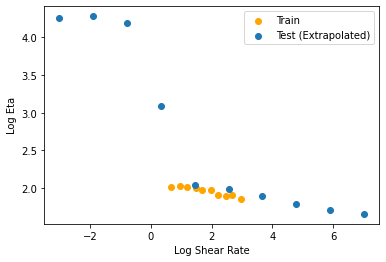

In [245]:
test_pred = m_NP.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])

plt.figure()
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
plt.scatter(np.log10(S_ex), test_pred)
plt.legend(['Train','Test (Extrapolated)'])

In [68]:
m_P

START TRAINING GPR FOR Mcr

In [47]:
me_data = pd.read_excel('Data/EntanglementMW_fp.xlsx')
fp = me_data[[c for c in me_data.columns if 'fp' in c]]
fp[[c for c in OG_fp if c not in fp]] = 0
fp = fp.drop(columns = [c for c in fp if c not in OG_fp])
y = M_scaler.transform(np.log10(np.array(me_data['Me']*2)).reshape(-1,1))
X_me = scaler.transform((pca.transform(fp[OG_fp])))

In [48]:
x_me, x_me_test, y_me, y_me_test = train_test_split(X_me, y, test_size = 0.1)

In [49]:
gpr_Mcr = create_GPR(X_me, y)

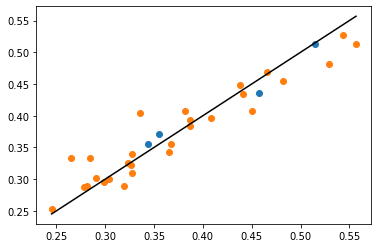

In [50]:
mcr_pred, var = gpr_Mcr.predict_y(x_me_test)
mcr_train_pred, var_train = gpr_Mcr.predict_y(x_me)
plt.scatter(y_me_test, mcr_pred)
plt.scatter(y_me, mcr_train_pred)
plt.plot(np.linspace((min(y)[0]), (max(y)[0]), num = 2),np.linspace((min(y)[0]), (max(y)[0]), num = 2),'k-')

In [15]:
tf.constant(mcr_pred)

<tf.Tensor: shape=(4, 1), dtype=float64, numpy=
array([[0.36688887],
       [0.42476719],
       [0.42645432],
       [0.34991337]])>

In [16]:
gpr_Mcr.predict_f_compiled = tf.function(
    gpr_Mcr.predict_f, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
)

In [17]:
tf.saved_model.save(gpr_Mcr, 'models')

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [18]:
gpr = tf.saved_model.load('models')

In [ ]:
gpr.predict_y(x_me)